In [1]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [824 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,265 kB]
Get:13 http://security.u

In [2]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql import SparkSession
import numpy as np
from datetime import datetime, timedelta
from pyspark.sql.window import Window
import numpy as np
import math
import pandas as pd
import subprocess
from google.colab import drive
import plotly.express as px
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

In [3]:
################################
appName = 'abd11FinalProject'
spark = SparkSession.builder\
                    .appName(appName) \
                    .getOrCreate()
sc = spark.sparkContext

In [4]:
spark

Load data

In [5]:
company_ticker = "GE"
filename = "ge.csv"
drive.mount('/content/gdrive')

download_dir = '/content/gdrive/My Drive/Colab Notebooks/' #download directory
os.chdir(download_dir) #move to directory

print(os.listdir())

# load the data from the csv file

combined_data = spark.read.csv(download_dir+filename, header=True, inferSchema=True)
combined_data = combined_data.orderBy("date")
combined_data.show()
combined_data.tail(7)

Mounted at /content/gdrive
['Untitled0.ipynb', 'Copia de NLP - Assignment 1.ipynb', 'Untitled (1)', 'onlinefoods.csv', 'Untitled1.ipynb', 'Cl4_SPARKSQL_ALU_v1.ipynb', 'Cl3_SPARKSQL_ALU_v1.ipynb', 'Untitled', 'Cl5_SPARKSQL_ALU_v1.ipynb', 'Final_Big_data.ipynb', 'ge.csv', 'Pablo_Model.ipynb']
+-----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+------+
|  cik|ticker|      date|              open|              high|               low|             close|          adjclose|     volume|    rn|
+-----+------+----------+------------------+------------------+------------------+------------------+------------------+-----------+------+
|40545|    GE|2018-01-02|105.56656646728516|108.02857971191406|105.26631927490234|107.96853637695312|  102.963134765625|1.2917782E7|107254|
|40545|    GE|2018-01-03|109.89010620117188|110.13031005859375|108.26878356933594|108.98937225341797| 103.9366455078125|1.3567582E7|107253|
|40545| 

[Row(cik=40545, ticker='GE', date=datetime.date(2024, 4, 15), open=157.1999969482422, high=158.69000244140625, low=152.69000244140625, close=153.6999969482422, adjclose=153.6999969482422, volume=6423700.0, rn=3673),
 Row(cik=40545, ticker='GE', date=datetime.date(2024, 4, 16), open=152.6999969482422, high=157.02000427246094, low=152.0, close=156.75999450683594, adjclose=156.75999450683594, volume=6187200.0, rn=3672),
 Row(cik=40545, ticker='GE', date=datetime.date(2024, 4, 17), open=158.0, high=158.67999267578125, low=153.6300048828125, close=155.6699981689453, adjclose=155.6699981689453, volume=6519900.0, rn=3671),
 Row(cik=40545, ticker='GE', date=datetime.date(2024, 4, 18), open=156.67999267578125, high=158.0, low=152.8800048828125, close=152.94000244140625, adjclose=152.94000244140625, volume=6186600.0, rn=3670),
 Row(cik=40545, ticker='GE', date=datetime.date(2024, 4, 19), open=153.4499969482422, high=153.52999877929688, low=146.77999877929688, close=148.05999755859375, adjclose=1

# Train a model with cross validation
## Split the data 80% 20% and evaluate on RMSE to get the best parameters for the model

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import year, month, dayofmonth

# Extract year, month, and day from the date column
data_with_features = combined_data.withColumn("year", year("date")) \
                                  .withColumn("month", month("date")) \
                                  .withColumn("day", dayofmonth("date"))
data_with_features = data_with_features.orderBy("date")

# Calculate the index to split at (80% train, 20% test)
split_index = int(0.8 * data_with_features.count())

# Split the data into train and test sets
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Define the features column
feature_columns = ['year', 'month', 'day']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the GBTRegressor
gbt = GBTRegressor(featuresCol="features", labelCol="close")

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, gbt])

# Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [3, 5, 7]) \
    .addGrid(gbt.maxIter, [20, 30]) \
    .build()

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")

# Create CrossValidator
cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=param_grid,
                           evaluator=evaluator,
                           numFolds=3)

# Fit the model
cv_model = cross_val.fit(train_data)

# Get best model
best_model = cv_model.bestModel

# Make predictions on the test set
predictions = best_model.transform(test_data)

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)

print("Root Mean Squared Error (RMSE) on test data =", rmse)

Root Mean Squared Error (RMSE) on test data = 49.22736326361659


In [7]:
params = [{p.name: v for p, v in m.items()} for m in cv_model.getEstimatorParamMaps()]
import pandas as pd

pd.DataFrame.from_dict([
    {cv_model.getEvaluator().getMetricName(): metric, **ps}
    for ps, metric in zip(params, cv_model.avgMetrics)
])

,rmse,maxDepth,maxIter
0,4.976898,3,20
1,4.300558,3,30
2,3.176291,5,20
3,3.001331,5,30
4,2.467697,7,20
5,2.421327,7,30


## The best parameters found by CV are maxDepth = 7 and maxIters = 30
### Now, train a model with that parameters for all days except the last 7 and finally predict the last 7 days with this best model

In [8]:
import time

# Get the last 7 days
split_index = int(data_with_features.count() - 7)

# Split the data by the last 7 days
train_data = data_with_features.limit(split_index)
test_data = data_with_features.subtract(train_data)

# Print length of thest data. Should be 7 days
print("Test data length:", test_data.count())

# Define the features column
feature_columns = ['year', 'month', 'day']
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define the GBTRegressor with the best parameters obtained from cross-validation
best_gbt = GBTRegressor(featuresCol="features", labelCol="close", maxDepth=7, maxIter=30)

# Create a pipeline
pipeline = Pipeline(stages=[vector_assembler, best_gbt])

# Fit the model on the entire dataset except the last 7 days
start_time = time.time()
model = pipeline.fit(train_data)
end_time = time.time()
print("Training time: {:.2f} seconds".format(end_time - start_time))

# Make predictions on the entire dataset
predictions = model.transform(test_data)

# Define evaluator
evaluator = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="close", predictionCol="prediction", metricName="r2")

# Evaluate the model on test data
rmse = evaluator.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Model results for last 7 days")
print("Root Mean Squared Error (RMSE) on test data =", rmse)
print("Mean Absolute Error (MAE) on test data =", mae)
print("R-squared (R2) on test data =", r2)

Test data length: 7
Training time: 16.43 seconds
Model results for last 7 days
Root Mean Squared Error (RMSE) on test data = 4.17036118866453
Mean Absolute Error (MAE) on test data = 3.438532949920593
R-squared (R2) on test data = -0.0174303910389626


In [9]:
predictions.show()

+-----+------+----------+------------------+------------------+------------------+------------------+------------------+---------+----+----+-----+---+-----------------+------------------+
|  cik|ticker|      date|              open|              high|               low|             close|          adjclose|   volume|  rn|year|month|day|         features|        prediction|
+-----+------+----------+------------------+------------------+------------------+------------------+------------------+---------+----+----+-----+---+-----------------+------------------+
|40545|    GE|2024-04-15| 157.1999969482422|158.69000244140625|152.69000244140625| 153.6999969482422| 153.6999969482422|6423700.0|3673|2024|    4| 15|[2024.0,4.0,15.0]|154.85469857234722|
|40545|    GE|2024-04-16| 152.6999969482422|157.02000427246094|             152.0|156.75999450683594|156.75999450683594|6187200.0|3672|2024|    4| 16|[2024.0,4.0,16.0]|154.86007373335354|
|40545|    GE|2024-04-17|             158.0|158.679992675781

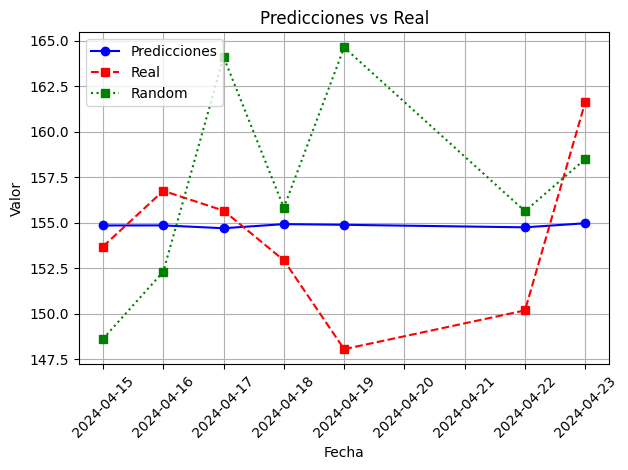

In [12]:
import matplotlib.pyplot as plt
import random

predictions = predictions.orderBy("date")

# Collecting data from DataFrame columns as lists
dates = predictions.select("date").rdd.flatMap(lambda x: x).collect()
predictions_values = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()
real_values = predictions.select("close").rdd.flatMap(lambda x: x).collect()
max_val = max(real_values) + 5
min_val = min(real_values) - 5
valores_random = [random.uniform(min_val, max_val) for _ in range(7)]

# Plotting the data
plt.plot(dates, predictions_values, label='Predicciones', linestyle='-', marker='o', color='b')
plt.plot(dates, real_values, label='Real', linestyle='--', marker='s', color='r')
plt.plot(dates, valores_random, label='Random', linestyle=':', marker='s', color='g')

# Labels and legend
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Predicciones vs Real')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()